In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using Truncated SVD.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Truncated SVD to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset. 
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

In [39]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display some of the datapoints from the loaded dataset.
print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])
filtered_data.head(5)

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [32]:
#This code block check how many entries are there from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", connection_sqlobject)

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [33]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [34]:
display['COUNT(*)'].sum()

393063

In [35]:
#Checking the number of entries that came from UserId="AR5J8UI46CURR"
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection_sqlobject)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [36]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [37]:
#Sorting data according to Time in ascending order. The oldest reviews will be displayed at the top and the new reviews will be display at the end of the dataset.
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [38]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered_duplicates.shape))

The shape of the data matrix after deduplication, Stage 1: (364173, 12)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [40]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [41]:
#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication, Stage 2: : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Delete unwanted variables to free up memory space
del(filtered_duplicates, filtered_data, display, sorted_data)

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication, Stage 2: : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


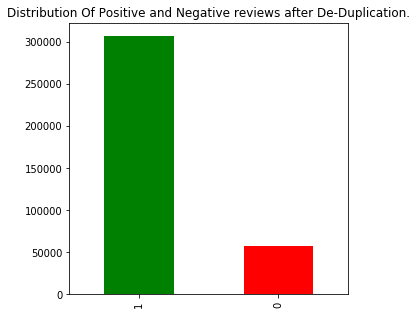

In [42]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
#Printing some random reviews from the deduplicated dataset.
sent_1 = final_data['Text'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Text'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Text'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Text'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Text'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)

sent_6 = final_data['Text'].values[255600]
print(sent_6)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[255600]))
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.
Review Polarity: Positive
At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My d

In [44]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)
sent_6 = re.sub(r"http\S+", " ", sent_6)

print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)
print(sent_6,"\n")
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful. 

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal. 

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again. 

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results. 

Excellent service, the product arri

In [45]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")
print(removeHtml(sent_6) + "\n")

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.  Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results.

Excellent service, the product arrived on time an

In [46]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [47]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.


In [73]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [13]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

<h2><font color='red'>[3.1] Preprocessing Review Text</font></h2>

100%|██████████| 70246/70246 [00:00<00:00, 797137.23it/s]


Text(0,0.5,'Number of Words')

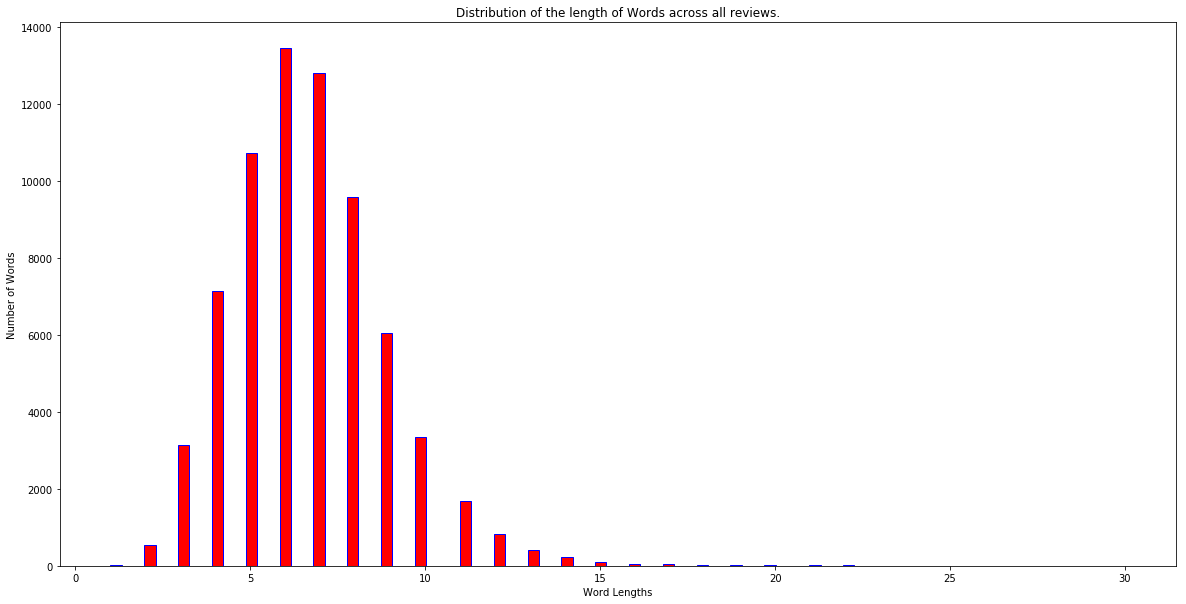

In [71]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram:
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [74]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|██████████| 364171/364171 [11:37<00:00, 521.74it/s]


The length of the data corpus is : 364171


<h2><font color='red'>[3.2] Preprocessing Review Summary + Saving the Processed DB for future use.</font></h2>

In [79]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

File is saved as 'totally_processed_DB.sqlite'


# [4] Load the processed database and the review corpus.

In [8]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

processed_db.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,CleanedSummary,Combined_Reviews
0,122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,premium bourbon madagascar vanilla vannila bea...,excel,premium bourbon madagascar vanilla vannila bea...
1,435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...,god aw,dabbler enjoy span entir spectrum tast will tr...
2,279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...,love this faucet,love faucet husband instal one old hous curren...
3,279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,gone treat dinner treat dog work run chanc los...,dog love,gone treat dinner treat dog work run chanc los...
4,466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,firm favorit breakfast time hous mani year pic...,quaker instant oatmeal dinosaur egg,firm favorit breakfast time hous mani year pic...


# [5] Task: Apply Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

## Featurization using TF-IDF Vectors.

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review.
For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector. 

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.

In [9]:
#Load the review text corpus.
X_train = processed_db['CleanedText']

#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(max_features=30000,use_idf=True, ngram_range=(1,1), dtype='float').fit(X_train)

X_vectors = tf_idf_obj.transform(X_train)

print("Total number of unique features(words) present in the review corpus: ",len(tf_idf_obj.get_feature_names()))

Total number of unique features(words) present in the review corpus:  30000


### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [10]:
#Function to get top N features
#I have used the code from: https://buhrmann.github.io/tfidf-analysis.html
def get_top_features(tf_idf_obj, feat_names, top_n_features):
    # returns a dataframe with top n features :
    feat_index = np.argsort(tf_idf_obj.idf_)
    top_features = [(feat_names[i], tf_idf_obj.idf_[i]) for i in feat_index[:top_n_features]]
    df_topFeatures = pd.DataFrame(data=top_features, columns = ['Top Words','TF-IDF Value'])
    return df_topFeatures

#Get the mean TF-IDF Scores
tfidf_mean = np.mean(X_vectors, axis = 0)
tfidf_mean = np.array(tfidf_mean)[0].tolist()

#List of all the feature names
feat_names = tf_idf_obj.get_feature_names()

#Get e DataFrame containing the top TFIDF words along with their scores.
top_n_features = 3000
top_features = get_top_features(tf_idf_obj, feat_names, top_n_features)
                                
#Print the top 10 features.
#Words are arranged in increasing order of idf_ scores. Remember, less idf_(inverse) scores means more important the document.
top_features.head(10)

,Top Words,TF-IDF Value
0,not,1.594635
1,like,2.141660
2,tast,2.158091
3,good,2.304124
4,love,2.351060
5,great,2.401735
6,flavor,2.435161
7,one,2.446004
8,product,2.466702
9,use,2.505328


### [5.2] Calulation of Co-occurrence matrix

In [23]:
#Generate the Co-Occurence Matrix
def get_coOccuranceMatrix(X_train, top_features, window): #window = 2 means 2 on either side of the given word. Lets look at an example. data = [a,b,c,d,e,f,g,h],
    print("Generating the Co Occurence Matrix....")       #if window = 2, for letter c, we will have neighborhood = [a,b,c,d,e]. for f -> [d,e,f,g,h]
    dim=top_features.shape[0]
    square_matrix = np.zeros((dim,dim),int)
    
    values = [i for i in range(0,top_features.shape[0])]  #Contains all the top TF-IDF Scores as values.
    keys = [str(i) for i in top_features['Top Words']]    #Contains all the corresponding features names as keys.
    lookup_dict = dict(zip(keys,values))                  #We will use this dictionary as a look up table 

    top_words= keys
    
    #Processing each reviews to build the co-occurence Matrix
    for reviews in tqdm(X_train):
        #Split each review into words
        words = reviews.split()
        lnt = len(words)
        for i in range(0,len(words),1):
            idx_of_neigbors= []
            if((i-window >= 0) and (i+window < lnt)):
                idx_of_neigbors = np.arange(i-window,i+window+1)
            elif((i-window < 0) and (i+window < lnt)): 
                idx_of_neigbors = np.arange(0, i+window+1)
            elif((i-window >= 0) and (i+window >= lnt)):
                idx_of_neigbors = np.arange(i-window, lnt)
            else:
                pass
            #nei = [words[x] for x in idx_of_neigbors]
            #print(words[i],"---------",nei)
            #print(idx_of_neigbors)
            
            for j in idx_of_neigbors:
                if((words[j] in top_words) and (words[i] in top_words)):
                    row_idx = lookup_dict[words[i]]     #Get the index of the ith word from the lookup table
                    col_idx = lookup_dict[words[j]]     #Get the index of the jth word from the lookup table
                    square_matrix[row_idx,col_idx] += 1 #If word[i] and word[j] occurs in a neighbourhood of 5, there co occurence will be increases by one.
                else:
                    pass
                    
    #Fill all the diagonal elements of the co-occurence matrix with 0, as co-occurence of a word with itlself is always zero.                
    np.fill_diagonal(square_matrix, 0) 
    print("Co Occurence Matrix is generated....")      
    
    #Create a co-occurence dataframe.
    co_occur_df=pd.DataFrame(data=square_matrix, index=keys, columns=keys)
    return co_occur_df

co_occur_matrix = get_coOccuranceMatrix(X_train, top_features, window=2)

#Save the co occurence matrix.
co_occur_matrix.to_csv('cooccurence.csv')

  0%|          | 55/364171 [00:00<23:24, 259.20it/s]

Generating the Co Occurence Matrix....


100%|██████████| 364171/364171 [30:31<00:00, 198.79it/s]


Co Occurence Matrix is generated....


### [5.3] Finding optimal value for number of components (n) to be retained.

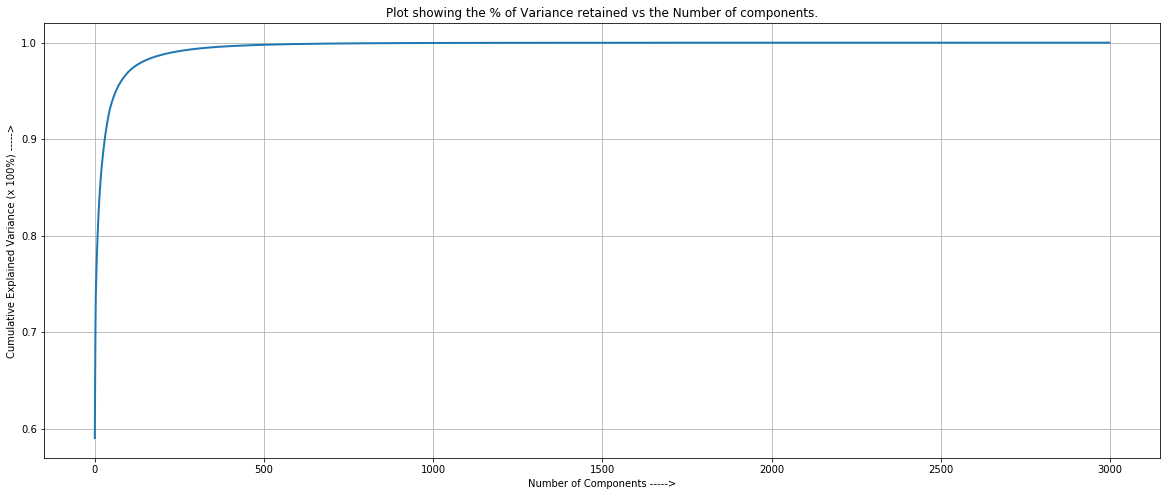

In [4]:
"""#Column standardize any input matrix.
def standardize(matrix):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=True).fit(matrix)
    df_standardize = scalar.transform(matrix)
    return df_standardize

#Standardize the co-occurence Matrix
co_occur_df_std = standardize(co_occur_df)"""

from sklearn.decomposition import TruncatedSVD
n = co_occur_df.shape[0]-1

#Inititalize the truncated SVD object.
svd = TruncatedSVD(n_components=n, 
                   algorithm='randomized', 
                   n_iter=10, 
                   random_state=0)
data=svd.fit_transform(co_occur_matrix)

cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(20, 8))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.title('Plot showing the % of Variance retained vs the Number of components.')
plt.xlabel('Number of Components ----->')
plt.ylabel('Cumulative Explained Variance (x 100%) ----->')
plt.show()

#### As we can see from the above plot, we can preserve the maximum amount of variance by reducing the dimensions to 500, i.e. n_components=500 makes the model retain almost 100% of the features. 

### [5.4] Applying k-means clustering

U = (3000, 500), Sigma = (500, 500), V.T = (500, 3000)


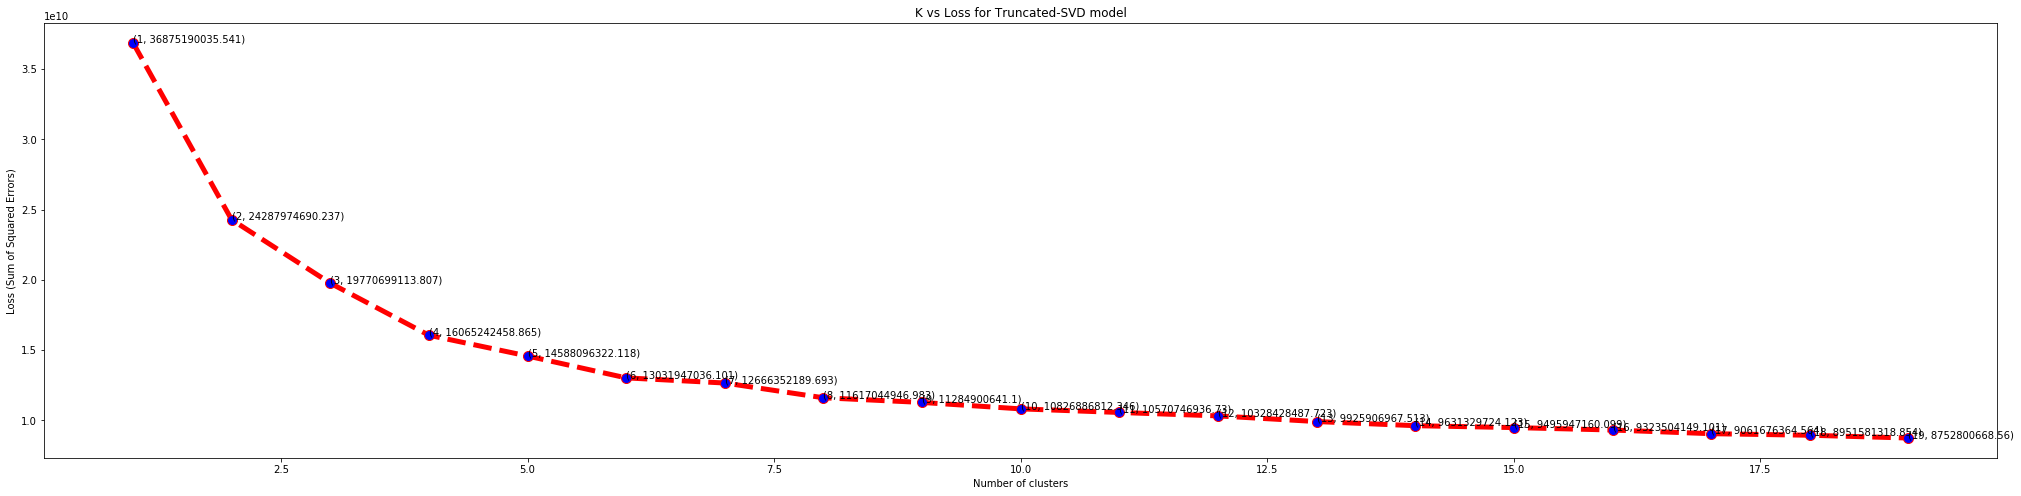

Please select the optimal numberof clusters from the above elbow plot and press enter : 5
The optimal number of clusters selected from the elbow method is 5


In [5]:
#Elbow method to determine the best value of K in K-Means clustering.
def plot_elbow(sumOfSquaredErrors, n_clusters, vectorizationType):
    '''This function is used to plot the elbow curve for sum of squared errors vs cluster values and obtain the optimal 
    value of the hyperparameter K.'''
        
    k_values = n_clusters
    loss = sumOfSquaredErrors
    
    #Plot K_Values vs Loss Values
    plt.figure(figsize=(35,8))
    plt.plot(k_values,loss,color='red',linestyle='dashed',linewidth=5,marker='o',markerfacecolor='blue',markersize=10)
    for xy in zip(k_values, np.round(loss,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('K vs Loss for {} model'.format(vectorizationType))
    plt.xlabel('Number of clusters')
    plt.ylabel('Loss (Sum of Squared Errors)')
    plt.show()
    
    optimal_k = input("Please select the optimal numberof clusters from the above elbow plot and press enter : ")
    print("The optimal number of clusters selected from the elbow method is {}".format(optimal_k))
    
    return optimal_k

#Function to perform KMeans Clustering.
def KMeansPlusPlus(U, vectorizationType):
    '''This function is used for multiple method calls which would determine the optimal value of k. The loss is calculated for each clusters and the value of the optimal 
    number of clusters is obtained by visualy examining the elbow plot. At the end the k-means algorithm will be run with the best value of K selected from the elbow plot'''
    
    sumOfSquaredErrors = []
    n_clusters = range(1,20)
    k_means = [KMeans(n_clusters=i, n_init=5, init='k-means++', n_jobs=8, random_state=0) for i in n_clusters] # elkan for dense data data
    k_means_centroids = [k_mean.fit(U) for k_mean in k_means]
    sumOfSquaredErrors = [k_mean.inertia_ for k_mean in k_means_centroids] # Inertia: Sum of distances of samples to their closest cluster center   
    
    optimal_k = int(plot_elbow(sumOfSquaredErrors, n_clusters, vectorizationType))
    return optimal_k

#This fucntion accepts a dataframe and matrix factorizes it to give U, Sigma, VT. 
def SVDTruncated(co_occur_matrix, n_components):
    svd = TruncatedSVD(n_components=n_components,
                   algorithm='randomized', 
                   random_state=0,
                   n_iter=10)
    U = svd.fit_transform(co_occur_matrix)
    VT = svd.components_
    Sigma = np.zeros((n_components,n_components),int)
    np.fill_diagonal(Sigma, svd.singular_values_)
    return (U, Sigma, VT)
    
    
n_components = 500 #Fitting the SVD with n=500 as obtained from the elbow method above.

#Factorize the co occurence matrix into U, Sigma and VT
U, Sigma, VT = SVDTruncated(co_occur_matrix, n_components)

#Display the shapes of the matrix factors after SVD
print("U = {}, Sigma = {}, V.T = {}".format(U.shape,Sigma.shape,VT.shape)) #MF Formulae for SVD : X = U * sigma * V.T => U contains <u1,u2,u3...ud> -> Word vectors corresponding to the top words

#KMeans++ Algorithm 
optimal_k = KMeansPlusPlus(U, 'Truncated-SVD')

#### Building a Kmeans++ model with optimal number of clusters obtained from the elbow plot above.

In [17]:
#Run k-medoids with the optimal number of clusters obtained from the elbow method and fit the model to SVD Transformed matrix
model = KMeans(n_clusters=optimal_k, n_init=5, init='k-means++', algorithm='auto', n_jobs=8, random_state=0)
model.fit(U)

'''#Predict the cluster labels
labels=model.predict(U)
print("\nThe predicted cluster labels are...")
print(labels)'''

#Get the cluster centroid values for all the clusters.
print("The cluster centroids are...")
print(model.cluster_centers_)

The cluster centroids are...
[[ 4.40824877e+02 -5.26333572e+01 -3.30080894e+00 ...  2.04904302e-01
  -1.52129774e-01  3.44207193e-01]
 [ 2.26815083e+04 -3.17732145e+03 -1.87887807e+03 ...  1.34886272e-01
   2.77074906e-02 -1.75738213e+00]
 [ 5.75428757e+03 -7.94157893e+02 -1.06854171e+01 ...  1.48240057e-01
   6.35025478e-01 -1.68900536e-01]
 [ 7.00218226e+04  4.13019662e+04  1.92207812e+03 ... -2.41723686e+00
   4.84673131e-01  4.05644780e-02]
 [ 4.52068798e+04 -8.42820748e+03  2.62628783e+04 ... -3.62169586e+00
  -1.03487220e+00  4.88466705e+00]]


### [5.5.1.1] Get number of words occuring in each cluster.

In [11]:
#Get number of words occuring in each cluster.
top_feats = [str(i) for i in top_features['Top Words']]
labels = list(set(model.labels_))
clusters_list = [] #clusters_list will contain all the clusters, i.e. it contains words in all the clusters. clusters_list[0] will contain words in cluster 0, clusters_list[1] in 1 and so on.
for i in labels:
    temp = []
    for word_idx in range(model.labels_.shape[0]): #model.labels_.shape[0]=3000
        if (model.labels_[word_idx] == i):
            temp.append(top_feats[word_idx])
    clusters_list.append(temp)

### [5.5.1.2] Wordclouds of clusters obtained in the above section

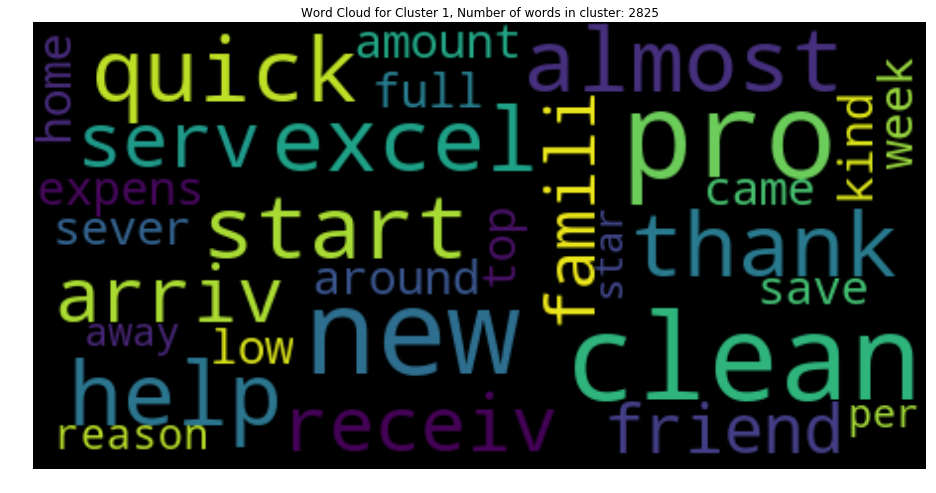

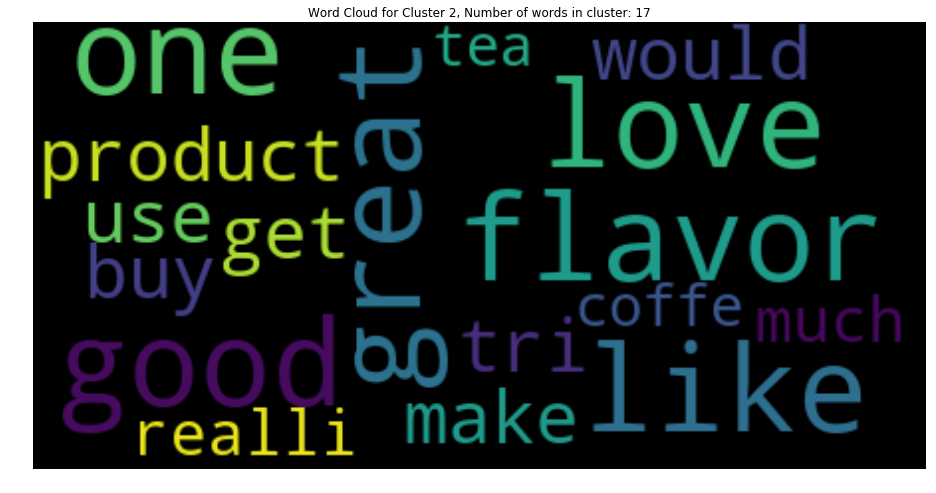

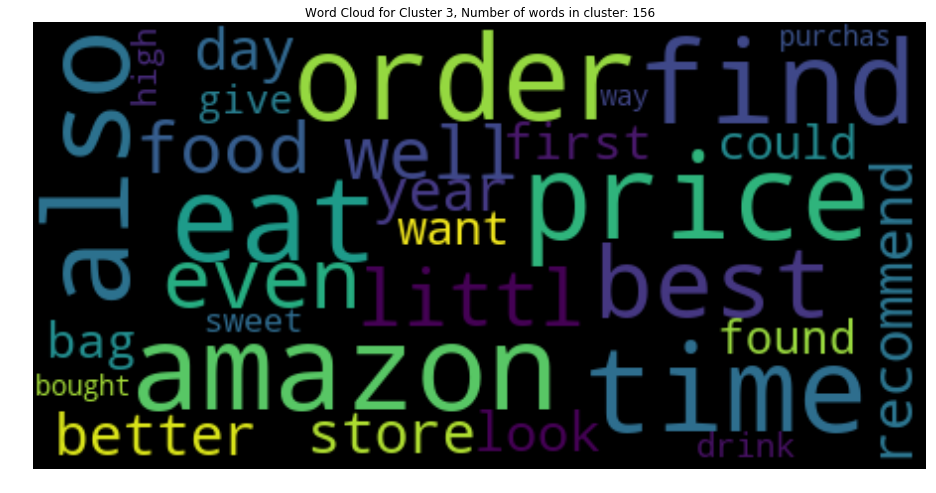

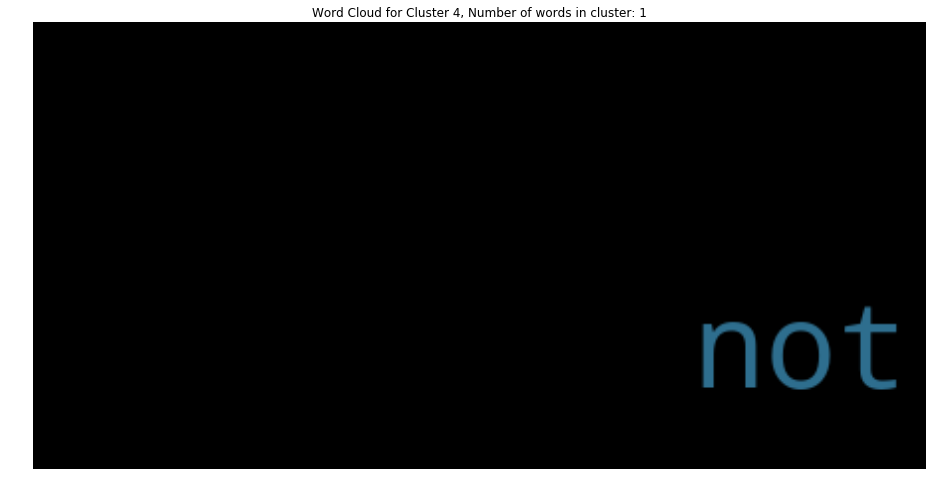

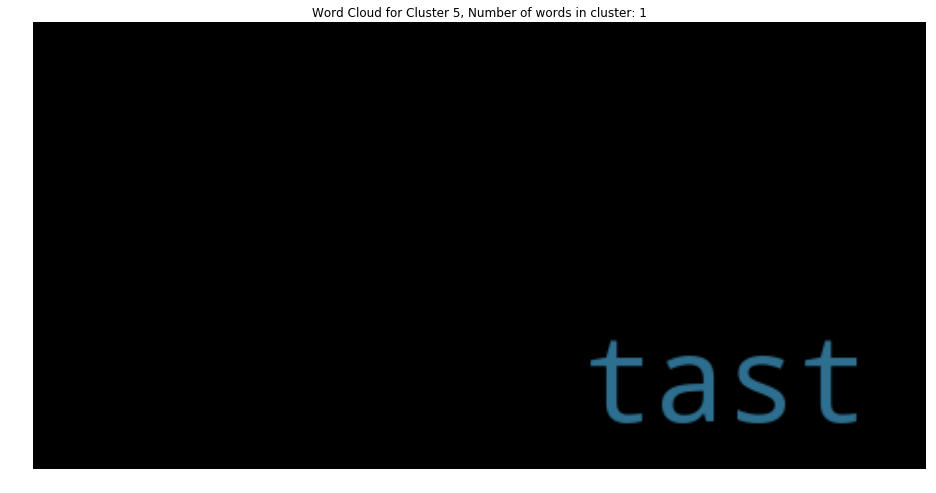

In [14]:
#Function to draw word clouds for each clusters.
from wordcloud import WordCloud 
def word_clouds(clusters_list):
    '''This method is used to draw word clouds for the top words which are groped together as different clusters.'''
    
    cluster_count = 1
    for cluster in clusters_list:
        word_corpus = ""
        for word in cluster:
            word_corpus = word_corpus + " " + word

        #lower max_font_size
        #we will select the maximum number of words from each cluster to be 20 to see the cluster at one go and understand briefly on what it means and how it has clustered data.
        wordcloud = WordCloud(width=450, height=225, max_words=30, random_state=5, stopwords=custom_stopwords, background_color='black', max_font_size=60, font_step=1, mode='RGB', repeat=False)
        wordcloud.generate(word_corpus)
        plt.figure(figsize=(16,9))
        plt.title("Word Cloud for Cluster {}, Number of words in cluster: {}".format(cluster_count,len(cluster)))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        cluster_count+=1

#Draw word cloud for each clusters
word_clouds(clusters_list)

#### Inference:

1. Cluster 1 has grouped words which are related to 'home', 'family' and positive feebacks about the delivery of 'products' on 'time'. It mostly talks about the arrival of new products.
2. Cluster 2 has grouped those words which are used mostly with 'coffee' and 'tea'. Cluster 1 says that 'good' is mostly used with 'great'. Also, 'good' and 'great' are most of the times used with the word 'like'.
3. Cluster 3 has rightly associated the words 'order' with 'amazon' and 'price'. All these are also associated with 'store' and 'food'
4. Only not is clustered.
5. Only taste is clustered.

### [5.5.2] Let's visualize the clusters in 2D using T-SNE.


T-SNE Plot for perplexity = 50


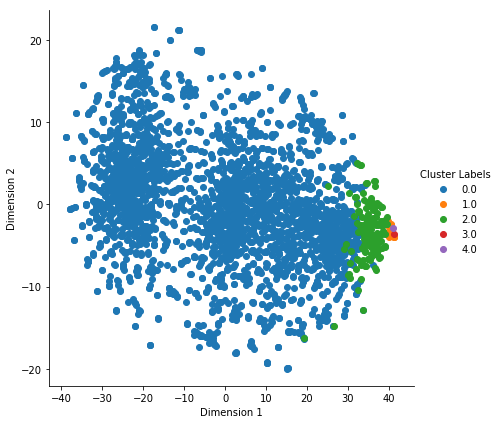

<Figure size 1080x720 with 0 Axes>

In [21]:
from MulticoreTSNE import MulticoreTSNE as TSNE

#Starting TSNE dataset transform
perplexity=50
tsne_model = TSNE(n_components=2, random_state=0, n_jobs=8, perplexity=perplexity, n_iter=5000)
tsne_data = tsne_model.fit_transform(U)

#Creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, model.labels_)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Cluster Labels"))

#Info
print("\nT-SNE Plot for perplexity = {}".format(perplexity))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Cluster Labels", height=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.figure(figsize=(15,10))
plt.show()    

### [5.6] Function that returns most similar words for a given word. Write a function that takes a word and returns the most similar words using cosine similarity between the vectors (vector: a row in the matrix after truncatedSVD)

In [30]:
#Function to obtain Cosine distances between any two vectors.
def cosine_sim(data_point1, data_point2):
    from numpy import dot
    from numpy.linalg import norm
    cos_dis = dot(data_point1, data_point2)/(norm(data_point1)*norm(data_point2))
    return (1-cos_dis) #cosine distance = 1 - cosine similarity

'''#Function to obtain Euclidean distances between any two vectors.
def get_euclidean_distance(data_point1, data_point2):
    distance = 0
    for i in range(len(data_point1)):
        distance += ((data_point1[i] - data_point2[i]) ** 2)
    distance = distance ** 0.5
    return distance
'''

#Function to obtain the 10 nearest words(semantically by meaning) for any input word, i.e. 
#a function that takes a word and returns the most similar words using cosine similarity between the vectors.
def get_nearest_words(U,top_features,input_word):
    print("Words related to '{}':".format(input_word))
    #Stemming and stopwords removal
    from nltk.stem.snowball import SnowballStemmer
    sno = SnowballStemmer(language='english')
    input_word=(sno.stem(input_word.lower()))
    top_words=list(top_features['Top Words'])
    if input_word in top_words:
        for i in range(len(top_words)):
            if input_word == top_words[i]:
                index = i
                
        similarity_values = []
        for i in range(U.shape[0]): #U contains word vectors corresponding to all words.
            similarity_values.append(cosine_sim(U[i], U[index]))
            
        sorted_indexes = np.array(similarity_values).argsort()


        
        #Display top 10 nearest words to the input words in a PrettyTable format.
        sim_words = []
        sim_scores = []
        for i in range(1, 11):
            sim_words.append(top_words[sorted_indexes[i]])
            sim_scores.append(1-similarity_values[sorted_indexes[i]])
        
        from prettytable import PrettyTable
        table = PrettyTable()
        table.add_column("Similar Words", sim_words)
        table.add_column("Similarity Scores", sim_scores)
        print(table)

    else:
        print("This word is not present in the vocabulary of top words.")
        
    print('\n')
        
#Get 10 nearest words for any given words.
get_nearest_words(U,top_features,"amazon")
get_nearest_words(U,top_features,"coffee")
get_nearest_words(U,top_features,"meat")
get_nearest_words(U,top_features,"cat")
get_nearest_words(U,top_features,"product")
get_nearest_words(U,top_features,"vanilla")
get_nearest_words(U,top_features,"bacon")
get_nearest_words(U,top_features,"like")

Words related to 'amazon':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|     onlin     | 0.8148516773609482 |
|     vendor    | 0.7634495059915761 |
|      item     | 0.7577276344931867 |
|    internet   | 0.7457165945044274 |
|    supplier   | 0.7411536811535906 |
|     seller    | 0.734839076186865  |
|      case     | 0.7311329491655091 |
|  distributor  | 0.7249591364117917 |
|     afford    | 0.7240746796261684 |
|     reason    | 0.7114088641422351 |
+---------------+--------------------+


Words related to 'coffee':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|      coff     | 0.9328692572175227 |
|     still     | 0.8157073257185797 |
|      also     | 0.8124376944675215 |
|   cappuccino  | 0.8044778130564872 |
|    consist    | 0.8004969773951783 |
|     howev     | 0.8002543801490419 |
|      tea      | 0.7999677282152174 |
|     co

# [6] Conclusions

In [19]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

<h5> We were also able to reduce the number of components from 3000 to 500, that too by retaining almost 100% of the features. </h5>
<h5> The optimal value of K we have obtained from the elbow plot is 5. </h5>




A brief summary on what we did so far: Took 100 data points arranged according to time. Preprocessed the dataset by removing unnecessary information. We kept only those words whose length was lesser than 16. Get the most important features using TF-IDF vectorizer along with their tf_idf scores. Remember, lesser the idf_ score, more important a word is. We then compute the co-occurence matrix from the tf-idf vectors and apply truncated SVD on it. Using matrix factorization we obtain the eigen vectors corresponding to dot(X.T,X). We have applied K means on the eigen vectors and cluster them into 5 clusters. We needed to perform hyperparameter tuning on the number of optimal clusters we needed for this job. We have selected the optimal value of K using the elbow method. Then we have drawn words clouds and visualized the clusters in 2-D space. The clustering was not extremely robust. This model can be improved more.  
